Plan

1. Preprocess data

2. Find variables with high correlation with tip amount variable

3. Use a RandomForestRegressor + RandomizedSearchCV to build a prediction model

4. Find feature importance of variables after model is finished training

5. Summarize results

# Data preprocessing

In [ ]:
!pip install pandas pyarrow

In [1]:
import pandas as pd

# concatenate all files into single dataframe
alldata = (pd.read_parquet(f"cleaned_data/1.parquet")).head(1500000)
for i in range(2, 13):
  alldata = pd.concat([alldata, (pd.read_parquet(f"cleaned_data/{i}.parquet")).head(1500000)])

In [2]:
# turn date-time into numerical values
alldata['tpep_pickup_datetime'] = pd.to_datetime(alldata['tpep_pickup_datetime']).astype('int64') // 1e9
alldata['tpep_dropoff_datetime'] = pd.to_datetime(alldata['tpep_dropoff_datetime']).astype('int64') // 1e9

In [3]:
# turn 'N' and 'Y' into 0 and 1
alldata["store_and_fwd_flag"] = alldata["store_and_fwd_flag"].map(lambda x: 0 if x == "N" else 1)

In [4]:
# drop unwanted columns
alldata = alldata.drop(columns=["yyyy-mm", "Airport_fee", "total_amount"])

# fillNA with zeroes
alldata["airport_fee"] = alldata["airport_fee"].fillna(0.00)

In [ ]:
alldata = alldata[(alldata['fare_amount'] >= 0) & (alldata['tip_amount'] >= 0)]

In [5]:
# one-hot encode nominal categories
alldata = pd.get_dummies(alldata, columns=['VendorID', 'RatecodeID', 'payment_type'], prefix_sep='_', dtype=int)

In [6]:
alldata.head()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,store_and_fwd_flag,PULocationID,DOLocationID,fare_amount,extra,mta_tax,...,RatecodeID_3.0,RatecodeID_4.0,RatecodeID_5.0,RatecodeID_6.0,RatecodeID_99.0,payment_type_1,payment_type_2,payment_type_3,payment_type_4,payment_type_5
0,1672533.0,1672533.0,1.0,0.97,0,161,141,9.3,1.00,0.5,...,0,0,0,0,0,0,1,0,0,0
1,1672534.0,1672534.0,1.0,1.10,0,43,237,7.9,1.00,0.5,...,0,0,0,0,0,1,0,0,0,0
2,1672532.0,1672533.0,1.0,2.51,0,48,238,14.9,1.00,0.5,...,0,0,0,0,0,1,0,0,0,0
3,1672531.0,1672532.0,0.0,1.90,0,138,7,12.1,7.25,0.5,...,0,0,0,0,0,1,0,0,0,0
4,1672531.0,1672532.0,1.0,1.43,0,107,79,11.4,1.00,0.5,...,0,0,0,0,0,1,0,0,0,0


# Variable Correlations

In [ ]:
!pip install seaborn

<Axes: >

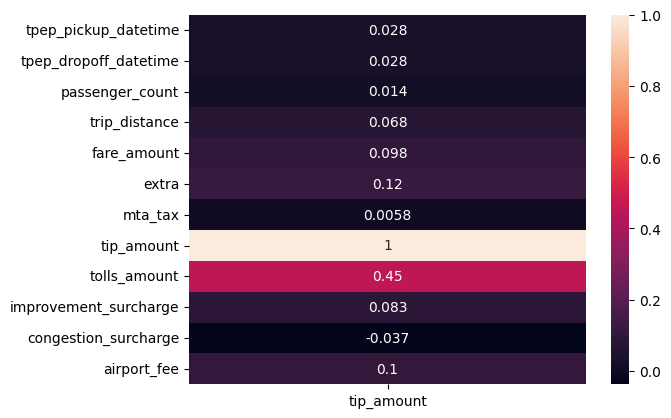

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# select numerical values
numericals = alldata.select_dtypes("float")

corr = numericals.corr()[['tip_amount']]
sns.heatmap(corr, annot=True)

# Building a Random Forest Model 

In [8]:
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import randint 

# get variables and target 
X = alldata.drop("tip_amount", axis=1)
y = alldata["tip_amount"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

forest = RandomForestRegressor(random_state=0, max_features=9, n_jobs=8)

# hyperparameters to search for
param_dist = {
    'n_estimators': randint(100, 250),
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': randint(2, 7),
    'min_samples_leaf': randint(1, 5)
}

random_search = RandomizedSearchCV(
    estimator=forest,
    param_distributions=param_dist,
    n_iter=5,
    cv=2,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state = 0
)

# Train the model with random search and find best parameter combination
random_search.fit(X_train, y_train)
print(f'Best Parameters: {random_search.best_params_}')

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 188}


In [9]:
# Use the Best Model
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse:.2f}')

RMSE: 3.20


# Feature importance

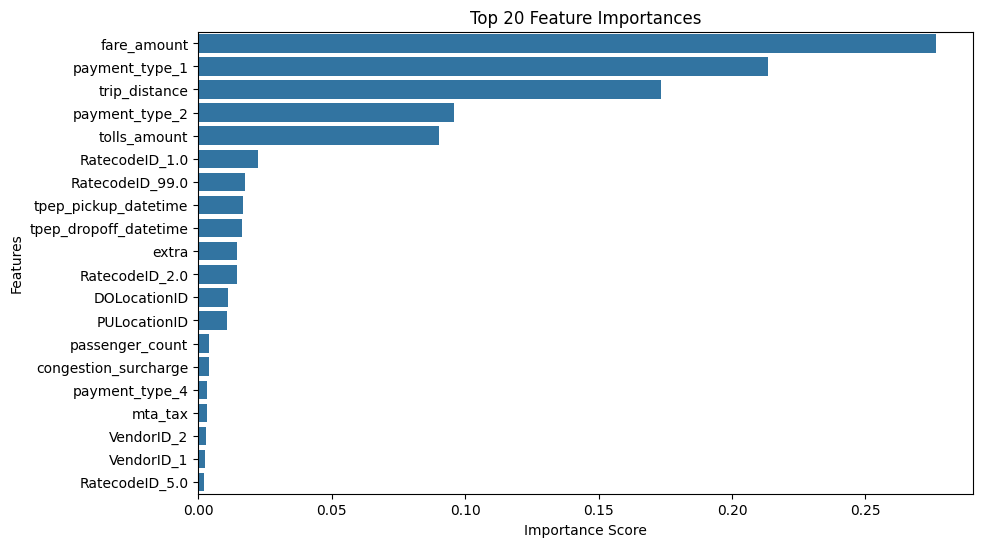

In [10]:
# Get feature importances
importances = best_model.feature_importances_

# Create a DataFrame for visualization
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

# Summary

The results show that the significant features for estimating tip amounts are:

fare_amount (The time-and-distance fare calculated by the meter)
payment_type_1 (credit card)
trip_distance (The elapsed trip distance in miles reported by the taximeter)
payment_type_2 (Cash)
tolls_amount (total amount of all tolls paid in trip)